## Merge daily images
The output from planetlabs is several different rasters as the area of interest will be over multiple images. This is due to how the imagery was taken. The images must be combined together through the process of merge.


In [1]:
import os
import json
import rasterio
import fiona
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
from rasterio.warp import calculate_default_transform, reproject, Resampling
import seaborn as sb
from itertools import chain
import rasterio.mask
import geopandas as gpd
import gdal
from sklearn.metrics import accuracy_score,confusion_matrix, cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import tsraster.model  as md
import tsraster.prep as tr
import pandas as pd
from tsraster.calculate import calculateFeatures, image_to_series, \
                                exportFeatures
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.preprocessing import StandardScaler
import numpy as np

import dask
import dask.dataframe as dd
from dask.distributed import Client
from xml.dom import minidom


from pyimpute import * 


In [1]:
inpath = "../Images_new"


os.chdir(r'C:\Users\mmann\Dropbox\IFPRI_Fire_India\NewCode')
from functions import merge_days, bai_rast_MS, ndvi_rast_MS, \
bai_rast_SR, ndvi_rast_SR, \
  merge_all_rast,find_unique_days,reproject_to_match, radiance_2_reflectance


NameError: name 'os' is not defined

## Create BAI and NDVI index


In [3]:
# Calculate NDVI and BAI 
inpath = "../Images_new"

name_pattern ='MS.tif'
unique_days = find_unique_days(inpath, name_pattern )
bad_patterns = ['*DN_udm.tif','*merge.tif','*SR.tif']


# create NDVI and BAI for each day 
for unique_day in unique_days:
    # get all images for day
    a_day_images = list(set(glob(os.path.join(inpath,'**/*'+ unique_day+'*'+name_pattern))))

    # remove all unwanted
    images_2_remove = [glob(os.path.join(inpath, '**/*'+unique_day+bad)) for bad in bad_patterns]
    images_2_remove = list(set(chain(*images_2_remove))) # unlist of lists 
    a_day_images_filtered = list(set(a_day_images) - set(images_2_remove))

    iterator = 0

    for an_image in a_day_images_filtered:
        
        print(an_image)
        # get coefficients to convert radiance to reflectance 
        r2r_dictionary = radiance_2_reflectance(an_image)
        
        bai_rast_MS(inpath=an_image, 
                 outpath=os.path.join(inpath,'bai',unique_day+"_"+str(iterator) + "_bai.tif"),
                r2r_dictionary = r2r_dictionary)
        
        ndvi_rast_MS(inpath=an_image, 
                 outpath=os.path.join(inpath,'ndvi',unique_day +"_"+str(iterator) + "_ndvi.tif"),
                 r2r_dictionary=r2r_dictionary)
        
        # write scaled reflectance values for false color composite exercise 
        write_reflectance(inpath=an_image, 
                  outpath=os.path.join(inpath,'reflectance',unique_day +"_"+str(iterator) + "_reflectance.tif"),
                  r2r_dictionary=r2r_dictionary)
        
        iterator= iterator + 1 

Unique Dates: ['20161126', '20161018', '20161121', '20161101', '20161213', '20161012', '20160828', '20161028', '20161027']
../Images_new\20161126_044358_0e3a\20161126_044358_0e3a_3B_AnalyticMS.tif
nir band reflectance is 0.0 0.1688351437992264   0.43851275662066924
red band reflectance is 0.0 0.1688351437992264   0.360511272835371


C:\Users\mmann\AppData\Local\Continuum\anaconda2\envs\ts-rasterv3\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


BAI band reflectance is nan nan   nan
../Images_new\20161126_044357_0e3a\20161126_044357_0e3a_3B_AnalyticMS.tif
nir band reflectance is 0.0 0.16727972708370958   0.6504788621176562
red band reflectance is 0.0 0.16727972708370958   0.437366766126668
BAI band reflectance is nan nan   nan
../Images_new\20161018_044252_0e1f\20161018_044252_0e1f_3B_AnalyticMS.tif
nir band reflectance is 0.0 0.182897913869688   0.465110209374264
red band reflectance is 0.0 0.182897913869688   0.334910320167153
BAI band reflectance is nan nan   nan
../Images_new\20161018_044250_0e1f\20161018_044250_0e1f_3B_AnalyticMS.tif
nir band reflectance is 0.0 0.1929529551346526   0.4262744341568132
red band reflectance is 0.0 0.1929529551346526   0.4064222771731868
BAI band reflectance is nan nan   nan
../Images_new\20161018_044251_0e1f\20161018_044251_0e1f_3B_AnalyticMS.tif
nir band reflectance is 0.0 0.1886927503039692   0.425609841522368
red band reflectance is 0.0 0.1886927503039692   0.3899014167734158
BAI band ref

## Merge Same Days into Single File

In [4]:
# MERGE SAME DAYS: Iterates through the unique list to select where files contain the same name 
#   and sets them up to be merged


# find all ndvi tifs 
name_pattern ='ndvi.tif'
unique_days = find_unique_days(inpath, name_pattern )
bad_patterns = ['*DN_udm.tif','*merge.tif','*MS.tif']

# merge by day 
for unique_day in unique_days:
    # get all images for day
    a_day_images = list(set(glob(os.path.join(inpath,'**/*'+ unique_day+'*'+name_pattern))))

    # remove all unwanted
    images_2_remove = [glob(os.path.join(inpath, '**/*'+unique_day+bad)) for bad in bad_patterns]
    images_2_remove = list(set(chain(*images_2_remove))) # unlist of lists 
    a_day_images_filtered = list(set(a_day_images) - set(images_2_remove))
    
    # merge same days 
    merge_days(outpath  = "../Images_new/merge", 
               outname =   unique_day + "_ndvi_merge.tif",
               files_unique = a_day_images_filtered)



# find all bai tifs 
name_pattern ='bai.tif'
unique_days = find_unique_days(inpath, name_pattern )
bad_patterns = ['*DN_udm.tif','*merge.tif','*MS.tif']

# merge by day 
for unique_day in unique_days:
    # get all images for day
    a_day_images = list(set(glob(os.path.join(inpath,'**/*'+ unique_day+'*'+name_pattern))))

    # remove all unwanted
    images_2_remove = [glob(os.path.join(inpath, '**/*'+unique_day+bad)) for bad in bad_patterns]
    images_2_remove = list(set(chain(*images_2_remove))) # unlist of lists 
    a_day_images_filtered = list(set(a_day_images) - set(images_2_remove))
    
    # merge same days 
    merge_days(outpath  = "../Images_new/merge", 
               outname =   unique_day + "_bai_merge.tif",
               files_unique = a_day_images_filtered)

Unique Dates: ['20161126', '20161018', '20161121', '20161101', '20161213', '20161012', '20160828', '20161028', '20161027']
File ../Images_new\ndvi\20161126_1_ndvi.tif
File ../Images_new\ndvi\20161126_0_ndvi.tif
mosiac shape:(1, 6992, 9549)
#################
Writing to ../Images_new/merge\20161126_ndvi_merge.tif
File ../Images_new\ndvi\20161018_1_ndvi.tif
File ../Images_new\ndvi\20161018_2_ndvi.tif
File ../Images_new\ndvi\20161018_0_ndvi.tif
mosiac shape:(1, 9731, 10105)
#################
Writing to ../Images_new/merge\20161018_ndvi_merge.tif
File ../Images_new\ndvi\20161121_2_ndvi.tif
File ../Images_new\ndvi\20161121_0_ndvi.tif
File ../Images_new\ndvi\20161121_1_ndvi.tif
mosiac shape:(1, 9602, 10022)
#################
Writing to ../Images_new/merge\20161121_ndvi_merge.tif
File ../Images_new\ndvi\20161101_1_ndvi.tif
File ../Images_new\ndvi\20161101_2_ndvi.tif
File ../Images_new\ndvi\20161101_0_ndvi.tif
mosiac shape:(1, 9719, 10032)
#################
Writing to ../Images_new/merge\201611

### write out reflectance values 

In [ ]:

# Write out reflectance values
inpath = "../Images_new"

name_pattern ='reflectance.tif'
unique_days = find_unique_days(inpath, name_pattern )
bad_patterns = ['*DN_udm.tif','*merge.tif','*SR.tif','*aux.xml']


# create NDVI and BAI for each day 
for unique_day in unique_days:
    print('unique day:')
    print(unique_day)
    # get all images for day
    a_day_images = list(set(glob(os.path.join(inpath,'**/*'+ unique_day+'*'+name_pattern))))

    # remove all unwanted
    images_2_remove = [glob(os.path.join(inpath, '**/*'+unique_day+bad)) for bad in bad_patterns]
    images_2_remove = list(set(chain(*images_2_remove))) # unlist of lists 
    a_day_images_filtered = list(set(a_day_images) - set(images_2_remove))

    iterator = 0

    # store a day of image readers 
    src_files_to_mosaic = []    

    for an_image in a_day_images_filtered:
         
        src = rasterio.open(an_image)
        src_files_to_mosaic.append(src)    
    
    print('a day')
    print(src_files_to_mosaic)
    
    # merge a days image
    mosaic, out_trans = merge(datasets=src_files_to_mosaic )
        
    # Copy the metadata
    out_meta = src.meta.copy()
    
    # Update the metadata
    out_meta.update({"driver": "GTiff",
                      "height": mosaic.shape[1],
                      "width": mosaic.shape[2],
                      "transform": out_trans,
                      #"crs": "+proj=utm +zone=35 +ellps=GRS80 +units=m +no_defs "
                      }
                     )
    
    out_fp = os.path.join(inpath,'multiband_merge','multiband_'+unique_day+'.tif')
    
    with rasterio.open(out_fp, "w", **out_meta) as dest:
          dest.write(mosaic)    

## Create blank example raster


In [5]:
#%% Create blank example raster with full extent of all images 

# Selects the files using a unique identifier and sets up the out paths
 
all_bai = glob(os.path.join(inpath,'**/*ndvi_merge.tif'))
outpath = os.path.join(inpath ,'combine', "all_merge.tif")


merge_all_rast(outpath, file_list=all_bai)



#%% Clip merged raster to shapefile to create example raster 


gdf= gpd.read_file(r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Shapefiles\right_cluster.geojson")
gdf = gdf.to_crs({'init': 'epsg:32643'})
gdf.to_file(r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Shapefiles\right_cluster_projected.geojson", driver='GeoJSON')

with fiona.open(r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Shapefiles\right_cluster_projected.geojson", "r") as shapefile:
    print(shapefile.crs)
    feature = [feature["geometry"] for feature in shapefile]


with rasterio.open(os.path.join(inpath ,'combine', "all_merge.tif")) as src:
    out_image, out_transform = rasterio.mask.mask(src, feature,
                                                        crop=True)
    out_meta = src.meta.copy()

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
        
with rasterio.open(os.path.join(inpath ,'combine', "all_merge_clip.tif"), "w", **out_meta) as dest:
    dest.write(out_image)

mosiac shape:(1, 15503, 23783)
{'init': 'epsg:32643'}


## Reproject and Resample
Make all images the same projection and extent of the empty raster

In [7]:
#%% reproject attempt 2 

all_images = glob(os.path.join(inpath,'**/*ndvi_merge.tif'))+glob(os.path.join(inpath,'**/*bai_merge.tif'))
 
for image in all_images:
    example_raster = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\combine\all_merge_clip.tif"
    out_name = os.path.join(inpath,'reproject', os.path.basename(image) )
    reproject_to_match(image, example_raster, out_name)
    

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000019E27CE5C30> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000019E2FED9D50> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000019E2FED9D50> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000019E27BCE5D0> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000019E27BCE5D0> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000019E2FED9E40> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000019E2FED9D50> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000019E27BCE5D0> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000019E27CE5D50> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000019E27BCE5D0> >
<osgeo.gdal.Dataset;

## Convert from float to Int


In [8]:
# ndvi_images = glob(os.path.join(inpath,'reproject','*ndvi_merge.tif')) 

# print(ndvi_images)
# for image in ndvi_images:
#     outpath  = os.path.join(inpath,'reproject','ndvi',os.path.basename(image))
    
#     with rasterio.open(image) as src:
#         data = src.read(1) * 10000
#         data = data.astype(np.int16)

#         data[np.isnan(data)]=-9999
#         out_meta = src.profile 

#         out_meta.update({"driver": "GTiff",
#                       "count":1,
#                       "dtype": 'int16',
#                       'nodata':-9999
#                       } )

#     # Saves out the raster according to the below criteria
#     with rasterio.open(outpath, 'w', **out_meta) as dst:
#             dst.write(data.astype(rasterio.int16), 1)

[]


In [20]:
# inpath
# bai_images =  glob(os.path.join(inpath,'reproject','*bai_merge.tif'))

# for image in bai_images:
#     outpath  = os.path.join(inpath,'reproject','bai',os.path.basename(image))

#     with rasterio.open(image) as src:
#         data = src.read(1) * 10000
#         data = data.astype(np.int16)

#         data[np.isnan(data)]=-9999

#         out_meta = src.profile 

#         out_meta.update({"driver": "GTiff",
#                       "count":1,
#                       "dtype": 'int16',
#                       'nodata':-9999
#                       } )

#     # Saves out the raster according to the below criteria
#     with rasterio.open(outpath, 'w', **out_meta) as dst:
#             dst.write(data.astype(rasterio.int16), 1)
            

## Extract Statistics and Classification

Moved the final data to a new folder and renamed them baireproject_2018105.tif etc... 

In [58]:
#directory
path = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\bai\1"
my_df = image_to_series(path)
print('df: '+os.path.join(path,'my_df.csv'))
my_df.to_csv(os.path.join(path,'my_df.csv'), chunksize=10000, index=False)
del my_df

path = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\bai\2"
my_df = image_to_series(path)
print('df: '+os.path.join(path,'my_df.csv'))
my_df.to_csv(os.path.join(path,'my_df.csv'), chunksize=10000, index=False)
del my_df

#directory
path = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\ndvi\1"
my_df = image_to_series(path)
print('df: '+os.path.join(path,'my_df.csv'))
my_df.to_csv(os.path.join(path,'my_df.csv'), chunksize=10000, index=False)
del my_df

path = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\ndvi\2"
my_df = image_to_series(path)
print('df: '+os.path.join(path,'my_df.csv'))
my_df.to_csv(os.path.join(path,'my_df.csv'), chunksize=10000, index=False)
del my_df

df: C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\bai\1\my_df.csv
df: C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\bai\2\my_df.csv
df: C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\ndvi\1\my_df.csv
df: C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\ndvi\2\my_df.csv


In [59]:
path = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\ndvi\1"
a = pd.read_csv(os.path.join(path,'my_df.csv'))
a.head()

,pixel_id,time,value,kind
0,0,ndvi,0.485552,20160828
1,0,ndvi,-9999.000000,20161012
2,0,ndvi,-9999.000000,20161018
3,0,ndvi,-9999.000000,20161028
4,1,ndvi,0.476450,20160828


In [60]:
c = a[a.value != -9999]
c.groupby('kind').agg(['count'])

,pixel_id,time,value
,count,count,count
kind,,,
20160828,65184250,65184250,65184250
20161012,29232681,29232681,29232681
20161018,54272163,54272163,54272163
20161028,17758796,17758796,17758796


In [61]:
path = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\bai\1"
b = pd.read_csv(os.path.join(path,'my_df.csv'))
b.head()

,pixel_id,time,value,kind
0,0,bai,1537.8351,20160828
1,0,bai,-9999.0000,20161012
2,0,bai,-9999.0000,20161018
3,0,bai,-9999.0000,20161028
4,1,bai,1289.7305,20160828


In [62]:
c = b[b.value != -9999]
c.groupby('kind').agg(['count'])

,pixel_id,time,value
,count,count,count
kind,,,
20160828,65184250,65184250,65184250
20161012,29232681,29232681,29232681
20161018,54272163,54272163,54272163
20161028,17758796,17758796,17758796


Merge peices together

In [63]:
# Merge my_dfs back together and export to parquet 
path = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\bai\1"
my_df = pd.read_csv(os.path.join(path,'my_df.csv'),index_col='pixel_id')
# replace missing values
my_df.replace(-9999, np.nan, inplace=True)
my_df.drop(columns=['kind'],inplace = True)

path2 = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\bai\2"
my_df2 = pd.read_csv(os.path.join(path2,'my_df.csv'),index_col='pixel_id')
# replace missing values
my_df2.replace(-9999, np.nan, inplace=True)
my_df2.drop(columns=['kind'],inplace = True)

#merge
my_df3 =pd.concat([my_df, my_df2])
del my_df2

my_df = dd.from_pandas(my_df, npartitions=1200)
my_df.to_parquet(os.path.join(r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\bai",
                              'my_df_no_missing.parquet') )

del my_df

C:\Users\mmann\AppData\Local\Continuum\anaconda2\envs\ts-rasterv3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [64]:
# Merge my_dfs back together and export to parquet 
path = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\ndvi\1"
my_df = pd.read_csv(os.path.join(path,'my_df.csv'),index_col='pixel_id')
# replace missing values
my_df.replace(-9999, np.nan, inplace=True)
my_df.drop(columns=['kind'],inplace = True)

path2 = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\ndvi\2"
my_df2 = pd.read_csv(os.path.join(path2,'my_df.csv'),index_col='pixel_id')
# replace missing values
my_df2.replace(-9999, np.nan, inplace=True)
my_df2.drop(columns=['kind'],inplace = True)

#merge
my_df =pd.concat([my_df, my_df2])
del my_df2

my_df = dd.from_pandas(my_df, npartitions=1200)
my_df.to_parquet(os.path.join(r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\ndvi",
                              'my_df_no_missing.parquet') )

del my_df

C:\Users\mmann\AppData\Local\Continuum\anaconda2\envs\ts-rasterv3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [25]:
client = Client(n_workers=8, 
                processes=True, memory_limit='15GB')
client

Client Scheduler: tcp://127.0.0.1:51160 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 16 Memory: 120.00 GB


In [26]:
path = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\bai"
df = dd.read_parquet(os.path.join(path,'my_df_no_missing.parquet'), index='pixel_id' )
#n = 1e6 # number of kbytes of target partition
#df.repartition(npartitions= 1+df.memory_usage(deep=True).sum().compute() // n )
df.npartitions
 

1200

In [27]:
bai_features = df.groupby('pixel_id').agg({'value': ['max','mean','min']}).compute()

In [28]:
bai_features.columns = ["_".join(x) for x in bai_features.columns.ravel()]
bai_features

,value_max,value_mean,value_min
pixel_id,,,
0,1537.83510,1537.835100,1537.83510
1,1289.73050,1289.730500,1289.73050
2,1280.96790,1280.967900,1280.96790
3,1805.29080,1805.290800,1805.29080
4,2039.81620,2039.816200,2039.81620
5,1654.97420,1654.974200,1654.97420
6,1286.82010,1286.820100,1286.82010
7,1127.75020,1127.750200,1127.75020
8,1027.03600,1027.036000,1027.03600


In [29]:
bai_features.to_parquet(os.path.join(path,'bai_features.parquet'), compression ='UNCOMPRESSED' )


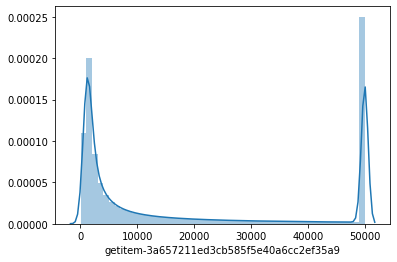

In [30]:
path = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\bai"
bai_features = dd.read_parquet(os.path.join(path,'bai_features.parquet'), index='pixel_id' )

sb.distplot(bai_features.value_max.values[~np.isnan(bai_features.value_max.values)])

In [31]:
bai_features.tail(20)

,value_max,value_mean,value_min
pixel_id,,,
65834133,50000.000,25104.162667,9396.8430
65834134,50000.000,25165.607333,11835.7660
65834135,50000.000,23598.578000,10185.8080
65834136,26968.420,17533.390667,12709.3260
65834137,20923.826,16771.585000,12984.1300
65834138,27482.586,21235.878667,12017.7700
65834139,50000.000,29898.904333,7930.0630
65834140,50000.000,24853.444000,6223.0020
65834141,50000.000,26238.561333,7225.5140


In [32]:
client.close()
del bai_features

In [3]:
client = Client(n_workers=7, 
                processes=True, memory_limit='15GB')
client

Client Scheduler: tcp://127.0.0.1:57346 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 7 Cores: 14 Memory: 105.00 GB


In [4]:
path = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\ndvi"
df = dd.read_parquet(os.path.join(path,'my_df_no_missing.parquet'), index='pixel_id' )
ndvi_features = df.groupby('pixel_id').agg({'value': ['max','mean','min']}).compute()
ndvi_features.columns = ["_".join(x) for x in ndvi_features.columns.ravel()]

ndvi_features.to_parquet(os.path.join(path,'ndvi_features.parquet'), compression ='UNCOMPRESSED' )
client.close()

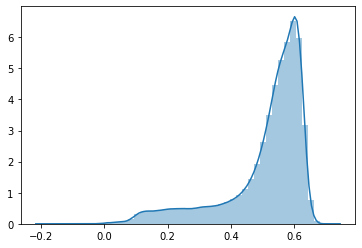

Future exception was never retrieved
future: <Future finished exception=TimeoutError('Timeout',)>
tornado.util.TimeoutError: Timeout


In [5]:
sb.distplot(ndvi_features.value_max.values)


## Combine BAI and NDVI features 

In [33]:
path = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject"
bai_features =  dd.read_parquet(os.path.join(path,'bai','bai_features.parquet'), index='pixel_id' )
bai_features.columns = ['bai_max', "bai_mean", 'bai_min']
ndvi_features =  dd.read_parquet(os.path.join(path,'ndvi','ndvi_features.parquet'), index='pixel_id' )
ndvi_features.columns = ['ndvi_max', "ndvi_mean", 'ndvi_min']


In [34]:
ndvi_features.persist()
bai_features.persist()


,bai_max,bai_mean,bai_min
npartitions=2,,,
0,float64,float64,float64
32917077,...,...,...
65834152,...,...,...


In [35]:
combined_features = dd.concat([bai_features, ndvi_features], axis=1).compute()


In [36]:
combined_features.fillna(combined_features.mean(), inplace=True)
print(combined_features.head())

            bai_max   bai_mean    bai_min  ndvi_max  ndvi_mean  ndvi_min
pixel_id                                                                
0         1537.8351  1537.8351  1537.8351  0.485552   0.385334  0.285117
1         1289.7305  1289.7305  1289.7305  0.476450   0.376513  0.276576
2         1280.9679  1280.9679  1280.9679  0.468452   0.358194  0.247936
3         1805.2908  1805.2908  1805.2908  0.463188   0.330371  0.197555
4         2039.8162  2039.8162  2039.8162  0.483314   0.326562  0.169810


In [43]:
for column in combined_features.columns:
    print(i)
r'C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\ts_features\\'+column+'.tif' 

ndvi_min
ndvi_min
ndvi_min
ndvi_min
ndvi_min
ndvi_min


'C:\\Users\\mmann\\Dropbox\\IFPRI_Fire_India\\Images_new\\ts_features\\\\ndvi_min.tif'

bai_max
bai_mean
bai_min
ndvi_max
ndvi_mean
ndvi_min


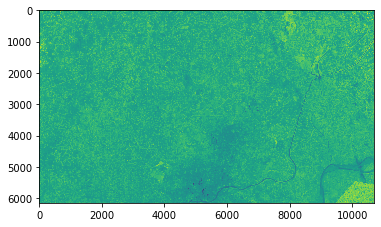

In [46]:
# convert TS features  back to raster 
example_raster = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\combine\all_merge_clip.tif"
ex_row, ex_cols =  rasterio.open(example_raster).shape

for column in combined_features.columns:
    print(column)
    f2Array =  combined_features[column].values.reshape(ex_row, ex_cols)
    plt.imshow(f2Array)

    output_raster = r'C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\ts_features\\'+column+'.tif' 

    with rasterio.open(example_raster) as src_dataset:

        kwds = src_dataset.profile
        kwds.update({
                'dtype': 'float32',
                'nodata': -9999
                })  

        with rasterio.open(output_raster, 'w', **kwds) as dst_dataset:
            # Write data to the destination dataset.
            dst_dataset.write_band(1, np.float32(f2Array))

 ## Example unsupervised classification
 ### Kmeans

In [8]:
# fit model
kmeans = KMeans(n_clusters=8, random_state=0, n_jobs=-2).fit(
                combined_features.sample(
                    frac=0.2, random_state=1)
                )
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=-2, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [9]:
# make predictions of classes to original data
class_preds = kmeans.predict(combined_features)

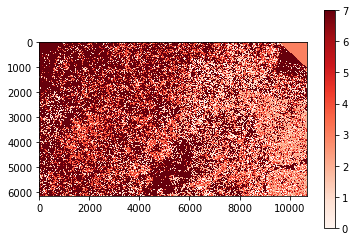

In [10]:
# convert classification  back to raster 
raster_ex = os.path.join(path,'ndvi','1','20160828_ndvi_merge.tif')
ex_row, ex_cols =  rasterio.open(raster_ex).shape

f2Array = class_preds.reshape(ex_row, ex_cols)
 # Plot the grid

plt.imshow(f2Array)
plt.set_cmap("Reds")
plt.colorbar( )
plt.show()

In [86]:
example_raster = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\combine\all_merge_clip.tif"
output_raster = r'C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\classifications\knn.tif'

with rasterio.open(example_raster) as src_dataset:

    kwds = src_dataset.profile
    kwds.update({
            'dtype': 'float32',
            'nodata': -9999
            })  
    
    with rasterio.open(output_raster, 'w', **kwds) as dst_dataset:
        # Write data to the destination dataset.
        dst_dataset.write_band(1, np.float32(f2Array))

### Scaled kmeans

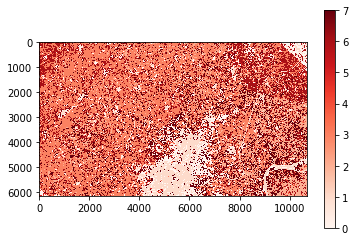

In [13]:
combined_features_scale = pd.DataFrame(StandardScaler().fit_transform(combined_features))
# fit model
kmeans = KMeans(n_clusters=8, random_state=0, n_jobs=-2).fit(
                combined_features_scale.sample(
                    frac=0.2, random_state=1)
                )
kmeans
# make predictions of classes to original data
class_preds = kmeans.predict(combined_features_scale)
# convert classification  back to raster 
raster_ex = os.path.join(path,'ndvi','1','20160828_ndvi_merge.tif')
ex_row, ex_cols =  rasterio.open(raster_ex).shape

f2Array = class_preds.reshape(ex_row, ex_cols)
 # Plot the grid

plt.imshow(f2Array)
plt.set_cmap("Reds")
plt.colorbar( )
plt.show()

In [14]:
example_raster = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\combine\all_merge_clip.tif"
output_raster = r'C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\classifications\knn_scaled.tif'

with rasterio.open(example_raster) as src_dataset:

    kwds = src_dataset.profile
    kwds.update({
            'dtype': 'float32',
            'nodata': -9999
            })  
    
    with rasterio.open(output_raster, 'w', **kwds) as dst_dataset:
        # Write data to the destination dataset.
        dst_dataset.write_band(1, np.float32(f2Array))

### Optics clustering

In [4]:
#combined_features_scale = pd.DataFrame(StandardScaler().fit_transform(combined_features))
#clust = OPTICS(min_samples=50, xi=.05, min_cluster_size=.05,n_jobs =-2).fit(
#                combined_features_scale.sample(
#                    frac=0.2, random_state=1)
#                )
 

In [ ]:
import joblib
joblib.dump(clust, 'C:\Users\mmann\Dropbox\IFPRI_Fire_India\Models\OPTICS.joblib')  

In [ ]:
# make predictions of classes to original data
class_preds = clust.predict(combined_features_scale)
# convert classification  back to raster 
raster_ex = os.path.join(path,'ndvi','1','20160828_ndvi_merge.tif')
ex_row, ex_cols =  rasterio.open(raster_ex).shape

f2Array = class_preds.reshape(ex_row, ex_cols)
 # Plot the grid

plt.imshow(f2Array)
#plt.set_cmap("Reds")
plt.colorbar( )
plt.show()

In [15]:
# DB SCAN (SKIPPING)
# # center and scale
# combined_features_scale = pd.DataFrame(StandardScaler().fit_transform(combined_features))

# # fit model
# db = DBSCAN(eps =1, min_samples =10, n_jobs = -2).fit(
#                         combined_features_scale
#             )

# ex_row, ex_cols =  rasterio.open(raster_ex).shape

# f2Array = db.reshape(ex_row, ex_cols)
#  # Plot the grid

# plt.imshow(f2Array)
# plt.set_cmap("Reds")
# plt.colorbar( )
# plt.show()

## Compare to training points
We need to compare our clusters to actual observations of burned areas. Ideally all burnt areas are part of the same cluster.

In [47]:
burn_points = gpd.read_file(r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Shapefiles\burnt_unburnt.shp")
right_cluster = gpd.read_file(r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Shapefiles\right_cluster.shp")
burn_points_new = gpd.read_file(r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Shapefiles\New_burned_training.shp")



output_raster = r'C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\classifications\knn_scaled.tif'
example_raster = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\combine\all_merge_clip.tif"

# reproject
burn_points = burn_points_new.to_crs(rasterio.open(output_raster).crs)
burn_points.head()

,Id,Burned,geometry
0,0,burned,POINT (727293.1294438748 3344400.528301735)
1,0,burned,POINT (727349.3535146562 3344536.127531266)
2,0,burned,POINT (727531.2549201257 3345045.451466581)
3,0,burned,POINT (724667.1346085519 3344860.24276283)
4,0,burned,POINT (724663.8273102705 3344916.466833612)


In [14]:
with rasterio.open(example_raster) as src_dataset:
    print(src_dataset.bounds)
    df = gpd.GeoDataFrame(gpd.GeoSeries(src_dataset.bounds), 
                          columns=['geometry'])
df

BoundingBox(left=703764.0, bottom=3333195.0, right=735873.0, top=3351648.0)


,geometry
0,703764.0
1,3333195.0
2,735873.0
3,3351648.0


In [15]:
# limit to right cluster of points (clipping)
xmin, ymin, xmax, ymax = df.geometry
burn_points = burn_points.cx[xmin:xmax, ymin:ymax]
burn_points.shape

(77, 3)

### Knearest comparison

#### raw point values 

(array([ 1.,  4.,  0., 53.,  0.,  0.,  0., 19.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <a list of 8 Patch objects>)

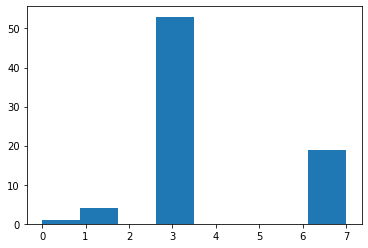

In [16]:
from rasterstats import zonal_stats  
from rasterstats import point_query
output_raster = r'C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\classifications\knn_scaled.tif'


burn_points_value = point_query(burn_points, 
                               raster=output_raster,
                               interpolate='nearest')
burn_points_value[1:5]
plt.hist(burn_points_value, bins=8)

#### buffer values

In [17]:
burn_points_buf = burn_points.copy()
burn_points_buf['geometry']= burn_points.buffer(15)
burn_points_buf.shape

(77, 3)

(array([ 1.,  4.,  0., 49.,  0.,  0.,  0., 23.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <a list of 8 Patch objects>)

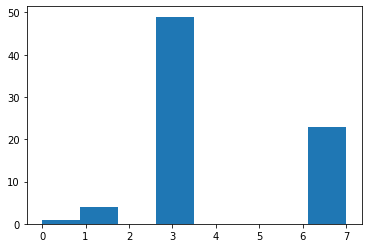

In [18]:
burn_points_buf_value = zonal_stats(burn_points_buf,
                                   raster=output_raster,
                                    stats='median',geojson_out=True)

burn_points_buf_value_df = gpd.GeoDataFrame.from_features(burn_points_buf_value)
#burn_points_buf_value_df
plt.hist(burn_points_buf_value_df['median'], bins=8)

unscaled might have better descrimint

## compare to max BAI
#### raw point values

(array([7., 0., 2., 0., 2., 3., 0., 2., 0., 1., 1., 0., 3., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]),
 array([ 631.90148926,  715.74950439,  799.59751953,  883.44553467,
         967.2935498 , 1051.14156494, 1134.98958008, 1218.83759521,
        1302.68561035, 1386.53362549, 1470.38164062, 1554.22965576,
        1638.0776709 , 1721.92568604, 1805.77370117, 1889.62171631,
        1973.46973145, 2057.31774658, 2141.16576172, 2225.01377686,
        2308.86179199, 2392.70980713, 2476.55782227, 2560.4058374 ,
        2644.25385254, 2728.10186768, 2811.94988281, 2895.79789795,
        2979.64591309, 3063.49392822, 3147.34194336, 3231.1899585 ,
        3315.03797363, 3398.88598877, 3482.73400391, 3566.58201904,
        3650.43003418, 3734.27804932, 3818.12606445, 3901.97407959,
        3985.82209473, 4069.67010986, 4153.518125  , 4237.36614014,
        4321.21415527, 440

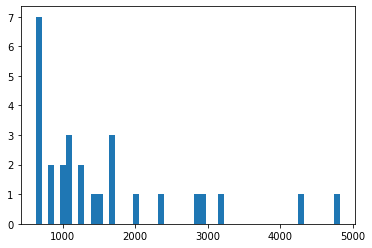

In [19]:
bai = r'C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\classifications\bai_max.tif'

burn_points_value = point_query(burn_points, 
                               raster=bai,
                               interpolate='nearest')
burn_points_value[1:5]
plt.hist(list(filter(lambda x: x < 5000, burn_points_value)), bins=50)

#### buffer values

(array([30.,  9.,  6.,  7.,  1.,  3.,  1., 20.]),
 array([  653.06628418,  6821.43299866, 12989.79971313, 19158.16642761,
        25326.53314209, 31494.89985657, 37663.26657104, 43831.63328552,
        50000.        ]),
 <a list of 8 Patch objects>)

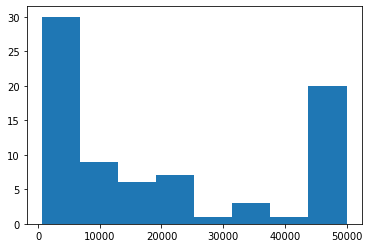

In [20]:
burn_points_buf_value = zonal_stats(burn_points_buf,
                                   raster=bai,
                                    stats='median',geojson_out=True)

burn_points_buf_value_df = gpd.GeoDataFrame.from_features(burn_points_buf_value)
#burn_points_buf_value_df
plt.hist(burn_points_buf_value_df['median'], bins='auto')

## Example supervised classification
 

In [52]:
#ts_features['Burned']=0
#ts_features.loc[(ts_features.baireproj__maximum > 0.8e7) &
#                (ts_features.baireproj__mean_change > 0) ,'Burned'] = 1
## isolate dependent variable and remove from independent variables
#Burned = ts_features['Burned']
##ts_features.drop(columns=['Burned'],inplace=True)
## print(Burned.head())
## print(ts_features.head())

Limit points to bounds of image

In [155]:
example_raster = r'C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\ts_features\bai_max.tif'
multiclass_points_new = gpd.read_file(r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Shapefiles\new_multiclass_burned.shp")


with rasterio.open(example_raster) as src_dataset:
    print(src_dataset.bounds)
    df = gpd.GeoDataFrame(gpd.GeoSeries(src_dataset.bounds), 
                          columns=['geometry'])
df

# limit to right cluster of points (clipping)
xmin, ymin, xmax, ymax = df.geometry
multiclass_points_new = multiclass_points_new.cx[xmin:xmax, ymin:ymax]
multiclass_points_new.reset_index(inplace=True)  # reset index
print(multiclass_points_new.shape)
multiclass_points_new.index

# remove 
multiclass_points_new.Class[multiclass_points_new.Class == 'uarban'] = 'urban'

BoundingBox(left=703764.0, bottom=3333195.0, right=735873.0, top=3351648.0)
(314, 4)


Extract values to new training points

In [165]:
features = []
names = []
for feature in glob(r'C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\ts_features\*.tif'): 
    feature_value = point_query(multiclass_points_new, 
                               raster=feature,
                               interpolate='nearest')
    names.append(os.path.basename(os.path.splitext(feature)[0]))
    features.append(feature_value)
    
print(names)
features = list(zip(*features)) # transpose
 

['bai_max', 'bai_mean', 'bai_min', 'ndvi_max', 'ndvi_mean', 'ndvi_min']


In [253]:
point_features = pd.DataFrame( features , columns=names)
#point_features['class'] = multiclass_points_new['Class']
point_features.head()

,bai_max,bai_mean,bai_min,ndvi_max,ndvi_mean,ndvi_min
0,29793.279297,15123.362305,453.443970,0.197807,0.118965,0.059763
1,989.442078,844.564880,699.687622,0.608914,0.256019,0.069585
2,4994.685547,3030.702881,1066.720215,0.604659,0.262779,0.075207
3,4317.822266,2763.947998,1210.073730,0.592439,0.303330,0.126570
4,1148.458374,1076.019287,1003.580078,0.577924,0.294668,0.138086


In [177]:
multiclass_points_new['Class'].value_counts()

burned       102
unharvest     80
harvest       64
urban         40
water         28
Name: Class, dtype: int64

In [209]:
from sklearn.model_selection import train_test_split as tts
y = multiclass_points_new.iloc[:,2]
X = point_features.iloc[:,1:]
X_train, X_test, y_train, y_test = tts(X, y,
                                           test_size=0.8,
                                           stratify=y,
                                           random_state=42)

In [238]:
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid) 

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [240]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(X_train,  y_train)

 

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   27.9s finished
C:\Users\mmann\AppData\Local\Continuum\anaconda2\envs\ts-rasterv3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [250]:
#out of sample performance
predict_test = clf.predict(X=X_test)

test_acc = accuracy_score(y_test, predict_test)
kappa = cohen_kappa_score(y_test, predict_test)
confusion = confusion_matrix(y_test, predict_test)

print('Testing accuracy:',test_acc)
print('Testing Kappa: ',kappa)
print('Testing Conf: ')
pd.DataFrame(confusion,columns= list(clf.classes_),index=list(clf.classes_))

Testing accuracy: 0.7579365079365079
Testing Kappa:  0.6793893129770993
Testing Conf: 


,burned,harvest,unharvest,urban,water
burned,63,14,5,0,0
harvest,22,28,1,0,0
unharvest,6,0,58,0,0
urban,0,1,0,27,4
water,5,0,0,3,15


(5, -0.5)

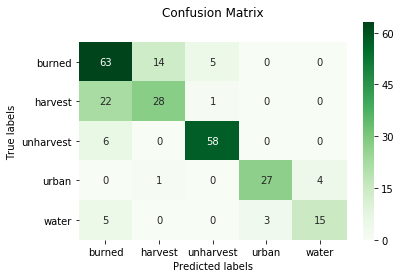

In [251]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(confusion, annot=True, cmap='Greens',ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(list(clf.classes_)); ax.yaxis.set_ticklabels(list(clf.classes_),rotation=0);
ax.set_ylim(len(list(clf.classes_)),-0.5,-1)

In [252]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_test.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
 
feature_importances

,importance
ndvi_min,0.444250
ndvi_max,0.260222
ndvi_mean,0.131539
bai_mean,0.079606
bai_min,0.050981
bai_max,0.033402


Make predictions back to the full original dataset

In [ ]:
# extract point values for prediction
#path = r'C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\ts_features'
#rasters = tr.image_to_series(path)

In [259]:
path = r'C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\ts_features'
rasters.to_csv(os.path.join(path,'features_df.csv'), chunksize=10000, index=False)
rasters.head()

,pixel_id,time,value,kind
0,0,max,1537.835083,bai
1,0,mean,1537.835083,bai
2,0,min,1537.835083,bai
3,0,max,0.485552,ndvi
4,0,mean,0.385334,ndvi


In [260]:
# make prediction of class
all_predict = md.model_predict(model = clf,
                                        new_X = rasters)

# returns probability of each class
all_prob =  md.model_predict_prob(model = clf,
                                        new_X = rasters)
print(all_predict.head())
print(all_prob.head())

distributed.core - INFO - Event loop was unresponsive in Nanny for 11.98s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 118.80s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 711.04s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 711.08s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 711.13s.  This is often caused by long-running GIL-holding functions or moving large chunks of dat

ValueError: could not convert string to float: 'ndvi'

distributed.core - INFO - Event loop was unresponsive in Nanny for 592.42s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


In [ ]:
# convert classification  back to raster 

raster_ex = os.path.join(path,'bai_max.tif')
ex_row, ex_cols =  rasterio.open(raster_ex).shape

f2Array = all_predict.values.reshape(ex_row, ex_cols)
 # Plot the grid

plt.imshow(f2Array)
plt.set_cmap("Reds")
plt.colorbar( )
plt.show()

In [ ]:
# convert classification PROBABILITY back to raster 

raster_ex = os.path.join(path,'bai_max.tif')
ex_row, ex_cols =  rasterio.open(raster_ex).shape

f2Array = all_prob[1].values.reshape(ex_row, ex_cols)
 # Plot the grid

plt.imshow(f2Array)
plt.set_cmap("Reds")
plt.colorbar( )
plt.show()

In [35]:
path = r'C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\ts_features'

# Define the known data points or "training" data
explanatory_fields = "ndvi_max ndvi_min ndvi_mean bai_mean bai_min bai_max".split()
explanatory_rasters = [os.path.join(path,  r + ".tif") for r in explanatory_fields]
response_shapes = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Shapefiles\new_multiclass_burned_select.shp"

# Load the training rasters using the sampled subset
try:
    cached = json.load(open("_cached_training.json"))
    train_xs = np.array(cached['train_xs'])
    train_y = np.array(cached['train_y'])
except IOError:
    train_xs, train_y = load_training_vector(response_shapes, 
        explanatory_rasters, response_field='Class')
    cache = {'train_xs': train_xs.tolist(), 'train_y': train_y.tolist()}
    with open("_cached_training.json", 'w') as fh:
        fh.write(json.dumps(cache))

print(train_xs.shape, train_y.shape)
print(train_xs[0:5] , train_y[0:5] )

#np.argwhere(np.isnan(list(train_xs) ))
#type(train_xs[0][0])
#np.argwhere(np.isnan())
[list(x) for x in train_xs]

(366, 6) (366,)
[[0.19780704379081726 0.059762921184301376 0.11896472424268723
  15123.3623046875 453.4439697265625 29793.279296875]
 [0.6089144349098206 0.06958544254302979 0.25601926445961
  844.5648803710938 699.6876220703125 989.4420776367188]
 [0.6046587228775024 0.07520680129528046 0.2627786099910736
  3030.702880859375 1066.72021484375 4994.685546875]
 [0.5924388766288757 0.12656950950622559 0.3033296763896942
  2763.947998046875 1210.07373046875 4317.822265625]
 [0.577923595905304 0.1380864679813385 0.29466816782951355
  1076.019287109375 1003.580078125 1148.4583740234375]] ['urban' 'burned' 'burned' 'harvest' 'harvest']


[[0.19780704379081726,
  0.059762921184301376,
  0.11896472424268723,
  15123.3623046875,
  453.4439697265625,
  29793.279296875],
 [0.6089144349098206,
  0.06958544254302979,
  0.25601926445961,
  844.5648803710938,
  699.6876220703125,
  989.4420776367188],
 [0.6046587228775024,
  0.07520680129528046,
  0.2627786099910736,
  3030.702880859375,
  1066.72021484375,
  4994.685546875],
 [0.5924388766288757,
  0.12656950950622559,
  0.3033296763896942,
  2763.947998046875,
  1210.07373046875,
  4317.822265625],
 [0.577923595905304,
  0.1380864679813385,
  0.29466816782951355,
  1076.019287109375,
  1003.580078125,
  1148.4583740234375],
 [0.628070056438446,
  0.1054759994149208,
  0.2835758626461029,
  602.4117431640625,
  205.4300079345703,
  999.3934326171875],
 [0.5391824841499329,
  0.11291477829217911,
  0.3096768856048584,
  7361.6884765625,
  2321.073974609375,
  12402.302734375],
 [0.5029476881027222,
  0.09141145646572113,
  0.2542470097541809,
  7059.7216796875,
  6798.878417968

In [10]:
# Train the classifier
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

(366, 6) (366,)
[[0.19780704379081726 0.059762921184301376 0.11896472424268723
  15123.3623046875 453.4439697265625 29793.279296875]
 [0.6089144349098206 0.06958544254302979 0.25601926445961
  844.5648803710938 699.6876220703125 989.4420776367188]
 [0.6046587228775024 0.07520680129528046 0.2627786099910736
  3030.702880859375 1066.72021484375 4994.685546875]
 [0.5924388766288757 0.12656950950622559 0.3033296763896942
  2763.947998046875 1210.07373046875 4317.822265625]
 [0.577923595905304 0.1380864679813385 0.29466816782951355
  1076.019287109375 1003.580078125 1148.4583740234375]] ['urban' 'burned' 'burned' 'harvest' 'harvest']


In [11]:
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(train_xs,  train_y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\mmann\AppData\Local\Continuum\anaconda2\envs\ts-rasterv3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [6]:
#clf = ExtraTreesClassifier(n_estimators=120, n_jobs=3)
#clf.fit(train_xs, train_y)
#print(clf)

evaluate_clf(rf, train_xs, train_y, feature_names=explanatory_fields)

(366, 6) (366,)
Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\mmann\AppData\Local\Continuum\anaconda2\envs\ts-rasterv3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').